<a href="https://colab.research.google.com/github/Dinmir331/Semester8_LB2/blob/main/S8_CV_LB2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2 лаба -- нужно взять 2 изображения (2 фотки пола например со сдвигом на сколько то сантиметров) или более и построить траекторию движения камеры, выполнив следующие пункты

Определите на каждой фотографии ключевые точки

Отфильтруйте самые наилучшие применяя адаптивный радиус и локальные максимумы, не забудьте так же выровнять по яркости изображения.

Постройте по каждой точке дескриптор (можете использовать любой, рекомендуется SIFT)

Сопоставьте два соседних изображения на предмет соответствия ключевых точек. То есть определите пары одинаковых точек.

Постройте модель преобразования изображений, учитывайте только поворот и сдвиг.
С учетом полученных моделей постройте траекторию движения камеры.

# Загрузка библиотек и данных. функции отображения изображений

## Основные библиотеки и подключение гугл диска

In [ ]:
# Загрузка библиотек и данных. Функции отображения изображений

## Основные библиотеки и подключение гугл диска

# Импорт необходимых библиотек
import numpy as np  # Для работы с массивами и численных операций
import cv2  # Библиотека OpenCV для обработки изображений
from matplotlib import pyplot as plt  # Для визуализации данных

# Подключение Google Drive для загрузки изображения
from google.colab import drive  # Импорт модуля для работы с Google Drive
drive.mount('/content/drive')  # Монтирование Google Drive для доступа к файлам

# Чтение изображения с использованием OpenCV и преобразование его в RGB
image1_path = '/content/drive/MyDrive/Colab Notebooks/LB2_IMAGE1_1.jpg'  # Путь к первому изображению
image2_path = '/content/drive/MyDrive/Colab Notebooks/LB2_IMAGE1_2.jpg'  # Путь ко второму изображению
image3_path = '/content/drive/MyDrive/Colab Notebooks/LB2_IMAGE1_3.jpg'  # Путь к третьему изображению
image4_path = '/content/drive/MyDrive/Colab Notebooks/LB2_IMAGE1_4.jpg'  # Путь к четвертому изображению

# Чтение изображений с помощью функции imread из OpenCV
image1 = cv2.imread(image1_path)  # Чтение первого изображения
image2 = cv2.imread(image2_path)  # Чтение второго изображения
image3 = cv2.imread(image3_path)  # Чтение третьего изображения
image4 = cv2.imread(image4_path)  # Чтение четвертого изображения

# Преобразование изображений из формата BGR (OpenCV) в RGB (для корректного отображения)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)  # Преобразование первого изображения
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)  # Преобразование второго изображения
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)  # Преобразование третьего изображения
image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)  # Преобразование четвертого изображения



Mounted at /content/drive


## Функция выравнивания яркости с адаптивным CLAHE

In [ ]:
# Функция для выравнивания яркости изображений с использованием CLAHE (Contrast Limited Adaptive Histogram Equalization)
def adjust_brightness(img):
    # Преобразование изображения в цветовое пространство LAB
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)  # LAB разделяет яркость (L) и цветность (A, B)

    # Разделение каналов LAB на L (яркость), A и B (цветовые компоненты)
    l, a, b = cv2.split(lab)  # Разделение на отдельные каналы

    # Создание объекта CLAHE с параметрами clipLimit и tileGridSize
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  # clipLimit ограничивает контраст, tileGridSize задает размер блоков

    # Применение CLAHE к каналу яркости (L)
    l = clahe.apply(l)  # Адаптивная коррекция яркости

    # Слияние обработанного канала яркости с исходными цветовыми каналами
    return cv2.cvtColor(cv2.merge([l,a,b]), cv2.COLOR_LAB2RGB)  # Обратное преобразование в RGB

# Применение коррекции яркости к каждому изображению
image1_adj = adjust_brightness(image1)  # Коррекция яркости первого изображения
image2_adj = adjust_brightness(image2)  # Коррекция яркости второго изображения
image3_adj = adjust_brightness(image3)  # Коррекция яркости третьего изображения
image4_adj = adjust_brightness(image4)  # Коррекция яркости четвертого изображения

# Обнаружение ключевых точек с ограничением количества

##SIFT

In [ ]:
# Обнаружение ключевых точек с ограничением количества

## SIFT (Scale-Invariant Feature Transform)
# Параметры contrast_thresh и edge_thresh зависят от масштаба:
# На мелких масштабах контрастные области могут быть менее заметны, и точки могут отсеиваться.
# На крупных масштабах края становятся более выраженными, что может привести к удалению точек на границах объектов.

# Меньшие значения scale (например, 1.0) подходят для мелких деталей.
# Большие значения scale (например, 8.0) подходят для крупных структур.

def homemade_sift(image,
                 nfeatures=1000,  # Максимальное количество ключевых точек
                 contrast_thresh=0.02,  # порог контраста
                 edge_thresh=12,  # порог краев
                 scales=[1.0, 1.6, 2.56, 4.0]):  # масштабы для поиска точек

    # 1. Предобработка изображения
    gray = image if len(image.shape) == 2 else cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Преобразование в градации серого
    h, w = gray.shape  # Получение размеров изображения

    # 2. Нахождение ключевых точек
    keypoints = []  # Список для хранения ключевых точек
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)  # Вычисление градиента по оси X
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)  # Вычисление градиента по оси Y
    magnitude = np.sqrt(sobelx**2 + sobely**2)  # Вычисление величины градиента

    for scale in scales:  # Итерация по масштабам
        blurred = cv2.GaussianBlur(gray, (0, 0), scale)  # Размытие Гаусса для каждого масштаба
        if scale > scales[0]:  # Вычисление разности Гауссиан (DoG) для всех масштабов, кроме первого
            dog = np.abs(blurred - prev_blur)

            for y in range(5, h-5):  # Итерация по пикселям изображения
                for x in range(5, w-5):
                    # Проверка порога контраста
                    if dog[y, x] < contrast_thresh:  # Если значение DoG меньше порога, пропускаем точку
                        continue

                    # Проверка на локальный экстремум в окне 5x5
                    neighborhood = dog[y-2:y+3, x-2:x+3]  # Окно 5x5 вокруг текущего пикселя
                    if dog[y, x] != np.max(neighborhood) and dog[y, x] != np.min(neighborhood):  # Если не экстремум, пропускаем
                        continue

                    # Улучшенная проверка краев (исключение точек на границах объектов)
                    trace = sobelx[y, x]**2 + sobely[y, x]**2  # След матрицы Гессе
                    det = (sobelx[y, x] * sobely[y, x])**2  # Определитель матрицы Гессе
                    if det == 0 or trace**2 / det > edge_thresh:  # Проверка на края
                        continue

                    # Добавление точки в список ключевых точек
                    keypoints.append(cv2.KeyPoint(x=x, y=y,
                                                 size=scale*2.5,  # Размер точки зависит от масштаба
                                                 response=magnitude[y, x]))  # Величина градиента как "ответ" точки
        prev_blur = blurred  # Сохранение текущего размытого изображения для следующего шага

    # 3. Фильтрация и сортировка ключевых точек
    keypoints = sorted(keypoints, key=lambda kp: kp.response, reverse=True)  # Сортировка по величине "ответа"

    # Адаптивная фильтрация для достижения nfeatures
    if len(keypoints) > nfeatures:  # Если точек больше, чем нужно, оставляем только топ-nfeatures
        keypoints = keypoints[:nfeatures]
    else:
        # Ослабляем требования при недостатке точек
        keypoints += [kp for kp in keypoints_sorted
                     if kp.size > 8 and kp.response > contrast_thresh/2][:nfeatures]

    # 4. Назначение ориентации для каждой ключевой точки
    orientation = np.arctan2(sobely, sobelx) * 180 / np.pi  # Вычисление направления градиента в градусах
    for kp in keypoints:
      x, y = int(kp.pt[0]), int(kp.pt[1])  # Координаты точки
      # Расширенная область для гистограммы (24x24 пикселя)
      hist, _ = np.histogram(orientation[y-12:y+12, x-12:x+12],
                          bins=72, range=(-180, 180))  # Построение гистограммы с 72 бинами
      dominant_angle = np.argmax(hist)  # Определение доминирующего угла
      kp.angle = float(dominant_angle * 5 - 180)  # Перевод индекса бина в угол (5 градусов на бин)

    # 5. Формирование дескрипторов для каждой ключевой точки
    descriptors = []
    # Создаем гауссову маску 24x24 для взвешивания пикселей
    sigma = 16
    y, x = np.mgrid[-sigma:sigma, -sigma:sigma]
    gaussian_mask = np.exp(-(x**2 + y**2)/(2*sigma**2))  # Гауссова функция для весов

    for kp in keypoints:
        x_center, y_center = int(kp.pt[0]), int(kp.pt[1])  # Центральная точка
        size = int(kp.size * 1.5)  # Размер области для дескриптора
        angle = np.deg2rad(kp.angle)  # Угол ориентации в радианах
        cos = np.cos(angle)  # Косинус угла
        sin = np.sin(angle)  # Синус угла

        desc = np.zeros((8, 8, 8))  # 8x8 блока × 8 бинов для дескриптора

        for i in range(8):  # Итерация по блокам
            for j in range(8):
                base_x = j * 3 - sigma  # Базовая координата X для блока
                base_y = i * 3 - sigma  # Базовая координата Y для блока

                for dx in range(3):  # Итерация по пикселям внутри блока
                    for dy in range(3):
                        rx = (base_x + dx) * cos - (base_y + dy) * sin  # Поворот по X
                        ry = (base_x + dx) * sin + (base_y + dy) * cos  # Поворот по Y
                        px = int(x_center + rx)  # Новые координаты X
                        py = int(y_center + ry)  # Новые координаты Y

                        if 0 <= px < w and 0 <= py < h:  # Проверка границ изображения
                            # Вес из гауссовой маски
                            weight = gaussian_mask[base_y + dy + sigma, base_x + dx + sigma]
                            mag = magnitude[py, px] * weight  # Взвешенная величина градиента
                            ori = orientation[py, px] - kp.angle  # Направление относительно ориентации точки
                            ori = ori % 360  # Приведение угла к диапазону [0, 360]
                            bin = int(ori // 45) % 8  # Индекс бина (8 бинов)
                            desc[i, j, bin] += mag  # Добавление значения в дескриптор

        # Многократная нормализация
        desc = desc.flatten()  # Преобразование в одномерный массив
        desc = np.clip(desc, 0, 0.2*np.max(desc))  # Ограничение максимального значения
        desc /= np.linalg.norm(desc) + 1e-7  # Нормализация дескриптора
        descriptors.append(desc)  # Добавление дескриптора в список

    return keypoints, np.array(descriptors, dtype=np.float32)  # Возвращаем ключевые точки и дескрипторы



##Вывод ключевых точек

In [ ]:
keypoints1, descriptors1 = homemade_sift(image1_adj)  # Применение функции к первому изображению
keypoints2, descriptors2 = homemade_sift(image2_adj)  # Применение функции ко второму изображению
keypoints3, descriptors3 = homemade_sift(image3_adj)  # Применение функции к третьему изображению
keypoints4, descriptors4 = homemade_sift(image4_adj)  # Применение функции к четвертому изображению

Обнаружено точек: 1000, 1000, 1000, 1000


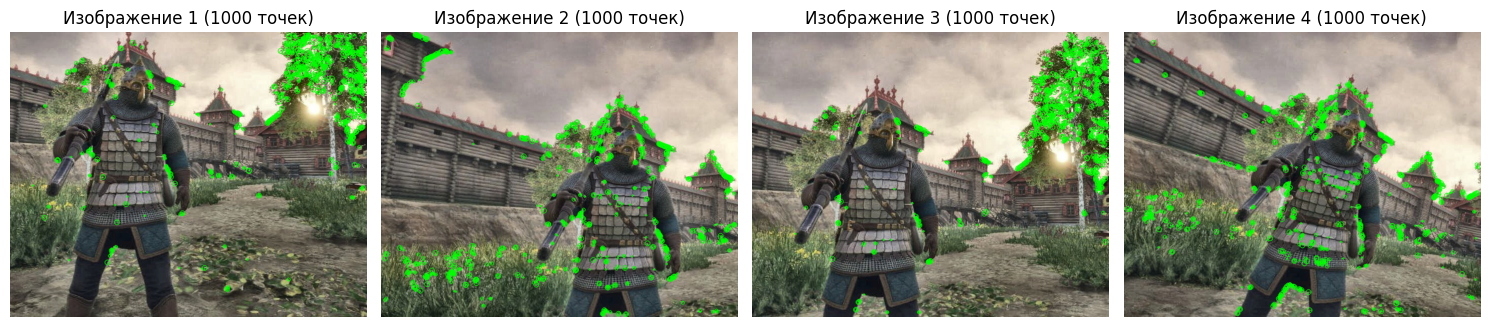

In [ ]:
print(f"Обнаружено точек: {len(keypoints1)}, {len(keypoints2)}, {len(keypoints3)}, {len(keypoints4)}")  # Вывод количества точек

def visualize_keypoints(images, keypoints_list):
    plt.figure(figsize=(15, 7))  # Создание фигуры для отображения
    for i, (img, kps) in enumerate(zip(images, keypoints_list), 1):  # Итерация по изображениям и ключевым точкам
        # Конвертируем RGB в BGR для OpenCV
        if len(img.shape) == 3 and img.shape[2] == 3:
            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        else:
            img_bgr = img

        # Рисуем точки на изображении
        img_with_kp = cv2.drawKeypoints(
            img_bgr,
            kps,
            None,
            color=(0, 255, 0),  # Зеленый цвет для точек
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS  # Отображение размера и ориентации точек
        )

        # Конвертируем обратно в RGB для matplotlib
        img_rgb = cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB)

        plt.subplot(1, len(images), i)  # Создание подграфика
        plt.imshow(img_rgb)  # Отображение изображения
        plt.title(f'Изображение {i} ({len(kps)} точек)')  # Заголовок с количеством точек
        plt.axis('off')  # Отключение осей
    plt.tight_layout()  # Автоматическое расположение графиков
    plt.show()  # Показать результат

# Пример использования:
visualize_keypoints([image1_adj, image2_adj, image3_adj, image4_adj],  # Список изображений
                    [keypoints1, keypoints2, keypoints3, keypoints4])  # Список ключевых точек

# Сопоставление и фильтрация совпадений встроенными функциями

In [ ]:
# bf = cv2.BFMatcher()
# matches = bf.knnMatch(descriptors1, descriptors2, k=4)

# # Фильтрация по Lowe's ratio test
# good_matches = [m for m,n in matches if m.distance < 0.7*n.distance]

# print(f"Найдено совпадений: {len(good_matches)}")

# Сопоставление и фильтрация совпадений


In [ ]:
# Функция для сопоставления дескрипторов между двумя изображениями
def manual_descriptor_matching(desc1, desc2, ratio=0.8):
    matches = []  # Список для хранения совпадений
    for idx1, d1 in enumerate(desc1):  # Итерация по дескрипторам первого изображения
        # Вычисляем расстояния до всех дескрипторов второго изображения
        # Используется Евклидово расстояние для сравнения дескрипторов
        distances = np.sqrt(np.sum((desc2 - d1)**2, axis=1))

        # Получаем индексы двух ближайших соседей (nearest neighbors)
        nn = np.argsort(distances)[:2]  # Сортировка расстояний и выбор двух минимальных

        # Проверяем тест Лоу (ratio test) для отфильтровки ложных совпадений
        # Если расстояние до ближайшего соседа значительно меньше, чем до второго,
        # то считаем это совпадение надежным
        if distances[nn[0]] < ratio * distances[nn[1]]:
            matches.append(cv2.DMatch(
                _queryIdx=idx1,  # Индекс дескриптора в первом изображении
                _trainIdx=nn[0],  # Индекс дескриптора во втором изображении
                _distance=distances[nn[0]]  # Расстояние между дескрипторами
            ))
    return matches  # Возвращаем список найденных совпадений

# Списки для хранения данных
images_adj = [image1_adj, image2_adj, image3_adj, image4_adj]  # Список обработанных изображений
keypoints = [keypoints1, keypoints2, keypoints3, keypoints4]  # Список ключевых точек для каждого изображения
descriptors = [descriptors1, descriptors2, descriptors3, descriptors4]  # Список дескрипторов для каждого изображения

# Создаем список пар изображений для анализа
num_images = len(images_adj)  # Количество изображений
pairs = []
for i in range(num_images - 1):
    pairs.append((i, i+1))  # Последовательные пары изображений (например, 1-2, 2-3 и т.д.)
pairs.append((0, num_images - 1))  # Добавляем пару между первым и последним изображением

pair_matches = []  # Список для хранения совпадений для каждой пары

# Обрабатываем все пары изображений
for idx, (i, j) in enumerate(pairs):  # Итерация по парам изображений
    if descriptors[i] is None or descriptors[j] is None:  # Проверка наличия дескрипторов
        print(f"Пара {i+1}-{j+1}: дескрипторы отсутствуют")
        pair_matches.append([])  # Если дескрипторы отсутствуют, добавляем пустой список
        continue

    # Ручное сопоставление дескрипторов между изображениями
    matches = manual_descriptor_matching(descriptors[i], descriptors[j])
    pair_matches.append(matches)  # Сохраняем найденные совпадения
    print(f"Пара {i+1}-{j+1}: Найдено {len(matches)} совпадений")  # Вывод количества совпадений

Пара 1-2: Найдено 23 совпадений
Пара 2-3: Найдено 30 совпадений
Пара 3-4: Найдено 10 совпадений
Пара 1-4: Найдено 24 совпадений


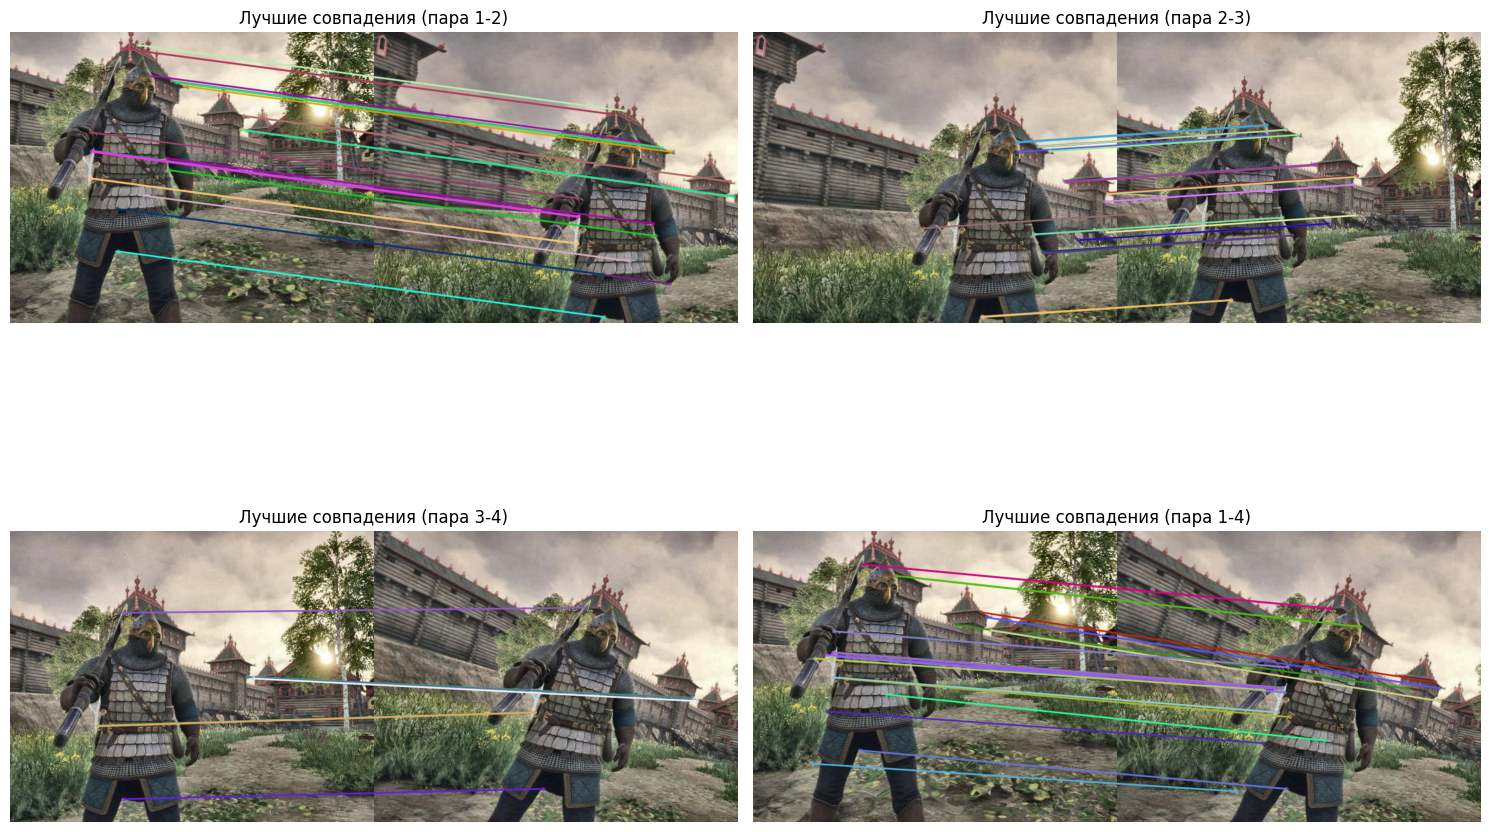

In [ ]:
# Визуализация совпадений с использованием OpenCV
plt.figure(figsize=(15, 12))  # Создание фигуры для отображения
for idx, (i, j) in enumerate(pairs):  # Итерация по парам изображений
    if len(pair_matches[idx]) == 0:  # Пропуск пар без совпадений
        continue

    plt.subplot(2, 2, idx+1)  # Создание подграфика для каждой пары
    match_img = cv2.drawMatches(
        images_adj[i], keypoints[i],  # Первое изображение и его ключевые точки
        images_adj[j], keypoints[j],  # Второе изображение и его ключевые точки
        pair_matches[idx][:50], None,  # Отображение только 50 лучших совпадений
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,  # Не рисовать одиночные точки
        matchesThickness=2  # Толщина линий для совпадений
    )
    plt.imshow(match_img)  # Отображение изображения с совпадениями
    plt.title(f'Лучшие совпадения (пара {i+1}-{j+1})')  # Заголовок с номером пары
    plt.axis('off')  # Отключение осей

plt.tight_layout()  # Автоматическое расположение графиков
plt.show()  # Показать результат

# оценка с использованием встроенной функции

In [ ]:
# trajectory = [(0, 0)]  # Начальная позиция
# current_pos = np.array([0.0, 0.0])
# total_rotation = 0.0

# plt.figure(figsize=(10, 10))

# for i in range(3):  # Две пары изображений
#     good_matches = pair_matches[i]
#     if len(good_matches) < 4:
#         print(f"Пара {i+1}-{i+2}: недостаточно совпадений")
#         continue

#     # Получение координат точек
#     src_pts = np.float32([keypoints[i][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
#     dst_pts = np.float32([keypoints[i+1][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

#     # Оценка преобразования
#     M, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts,
#                                       ransacReprojThreshold=3.0,
#                                       confidence=0.99)
#     if M is None:
#         print(f"Пара {i+1}-{i+2}: ошибка оценки преобразования")
#         continue

#     # Извлечение параметров движения
#     dx = -M[0, 2] # Инвертируем знак смещения по X
#     dy = M[1, 2]
#     rotation = np.arctan2(M[1, 0], M[0, 0]) * 180 / np.pi


#     # Обновление траектории
#     current_pos += np.array([dx, dy])
#     total_rotation += rotation
#     trajectory.append(tuple(current_pos))

# Оценка преобразования и траектории

In [ ]:
# Функция для оценки аффинного преобразования между двумя наборами точек
def estimate_affine_transform(src_pts, dst_pts):
    """
    Оценивает аффинное преобразование между двумя наборами точек.
    Возвращает матрицу преобразования 2x3.
    """
    # Формируем систему уравнений для метода наименьших квадратов (Least Squares)
    A = []  # Матрица коэффициентов
    b = []  # Вектор правой части уравнения
    for (x1, y1), (x2, y2) in zip(src_pts, dst_pts):  # Итерация по парам точек
        # Добавляем строки для расчета параметров преобразования
        A.append([x1, y1, 1, 0, 0, 0])  # Для X-координаты
        A.append([0, 0, 0, x1, y1, 1])  # Для Y-координаты
        b.append(x2)  # Целевая X-координата
        b.append(y2)  # Целевая Y-координата

    # Решаем систему уравнений методом наименьших квадратов
    A = np.array(A)  # Преобразуем в массив NumPy
    b = np.array(b)  # Преобразуем в массив NumPy
    params, _, _, _ = np.linalg.lstsq(A, b, rcond=None)  # Находим параметры модели

    # Формируем матрицу аффинного преобразования 2x3
    M = np.array([
        [params[0], params[1], params[2]],  # Первая строка матрицы
        [params[3], params[4], params[5]]   # Вторая строка матрицы
    ])
    return M  # Возвращаем матрицу преобразования

# Функция RANSAC для фильтрации выбросов и оценки лучшего преобразования
def apply_ransac(src_pts, dst_pts, threshold=3.0, max_iterations=1000):
    """
    Применяет RANSAC для фильтрации выбросов и возвращает лучшее преобразование.
    """
    best_M = None  # Лучшая матрица преобразования
    best_inliers = []  # Лучший набор внутренних точек
    num_points = len(src_pts)  # Количество точек

    for _ in range(max_iterations):  # Повторяем процесс заданное количество раз
        # Выбираем случайные 3 точки для оценки модели
        indices = np.random.choice(num_points, 3, replace=False)  # Случайные индексы
        sample_src = src_pts[indices]  # Точки исходного изображения
        sample_dst = dst_pts[indices]  # Точки целевого изображения

        # Оцениваем преобразование по выборке
        M = estimate_affine_transform(sample_src, sample_dst)

        # Вычисляем ошибки для всех точек
        transformed = np.dot(np.hstack([src_pts, np.ones((num_points, 1))]), M.T)  # Применяем преобразование
        errors = np.linalg.norm(transformed - dst_pts, axis=1)  # Расчет ошибок

        # Находим индексы внутренних точек (inliers)
        inliers = np.where(errors < threshold)[0]

        # Обновляем лучшую модель, если текущая лучше
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_M = M

    # Пересчитываем модель по всем внутренним точкам
    if len(best_inliers) > 0:
        best_M = estimate_affine_transform(src_pts[best_inliers], dst_pts[best_inliers])
    return best_M, best_inliers  # Возвращаем лучшую матрицу и набор внутренних точек


# Визуализация траектории



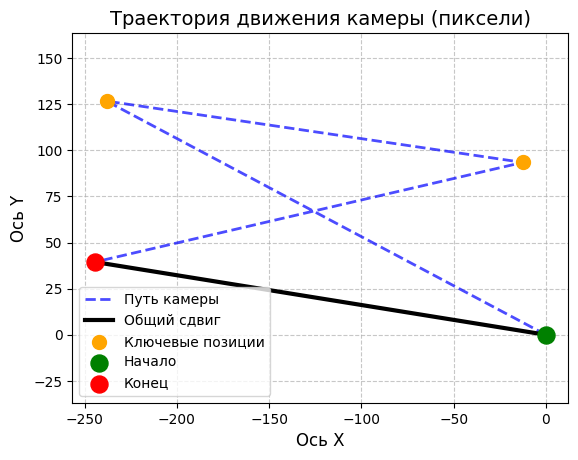

Финальная позиция: (-244.4 px, 39.4 px)
Общий поворот: 13.1 градусов


In [ ]:
trajectory = [(0, 0)]  # Начальная позиция камеры
current_pos = np.array([0.0, 0.0])  # Текущая позиция
total_rotation = 0.0  # Общий поворот камеры

plt.figure(figsize=(10, 10))  # Создаем фигуру для визуализации

for i in range(3):  # Обрабатываем три пары изображений
    good_matches = pair_matches[i]  # Совпадения для текущей пары изображений
    if len(good_matches) < 4:  # Если совпадений меньше 4, пропускаем пару
        print(f"Пара {i+1}-{i+2}: недостаточно совпадений")
        continue

    # Получение координат точек
    src_pts = np.float32([keypoints[i][m.queryIdx].pt for m in good_matches])  # Точки первого изображения
    dst_pts = np.float32([keypoints[i+1][m.trainIdx].pt for m in good_matches])  # Точки второго изображения

    # Оценка преобразования с использованием RANSAC
    M, inliers = apply_ransac(src_pts, dst_pts, threshold=3.0)
    if M is None:  # Если преобразование не найдено, пропускаем пару
        print(f"Пара {i+1}-{i+2}: ошибка оценки преобразования")
        continue

    # Извлечение параметров движения
    dx = -M[0, 2]  # Смещение по оси X (инвертируем знак для корректности направления)
    dy = M[1, 2]  # Смещение по оси Y
    rotation = np.arctan2(M[1, 0], M[0, 0]) * 180 / np.pi  # Угол поворота в градусах

    # Обновление траектории
    current_pos += np.array([dx, dy])  # Обновляем текущую позицию
    total_rotation += rotation  # Обновляем общий угол поворота
    trajectory.append(tuple(current_pos))  # Добавляем новую позицию в траекторию

x, y = zip(*trajectory)  # Разделяем координаты X и Y

# Линия полной траектории
plt.plot(x, y, 'b--', alpha=0.7, linewidth=2, label='Путь камеры')  # Линия пути

# Прямая между начальной и конечной точками
plt.plot([x[0], x[-1]], [y[0], y[-1]], 'black', linewidth=3, label='Общий сдвиг')  # Общий сдвиг

# Маркеры позиций
plt.scatter(x, y, c='orange', s=100, label='Ключевые позиции', zorder=5)  # Ключевые позиции
plt.scatter(x[0], y[0], c='green', s=150, label='Начало', zorder=5)  # Начальная точка
plt.scatter(x[-1], y[-1], c='red', s=150, label='Конец', zorder=5)  # Конечная точка

# Дополнительные настройки графика
plt.title('Траектория движения камеры (пиксели)', fontsize=14)  # Заголовок
plt.xlabel('Ось X', fontsize=12)  # Подпись оси X
plt.ylabel('Ось Y', fontsize=12)  # Подпись оси Y
plt.legend(loc='lower left', fontsize=10)  # Легенда
plt.grid(True, linestyle='--', alpha=0.7)  # Сетка
plt.axis('equal')  # Одинаковый масштаб осей
plt.show()  # Отображение графика

# Вывод финальных результатов
print(f"Финальная позиция: ({current_pos[0]:.1f} px, {current_pos[1]:.1f} px)")  # Финальная позиция
print(f"Общий поворот: {total_rotation:.1f} градусов")  # Общий угол поворота